# Train on notebook

In [1]:
# Basic libraries
import torch
import torch.nn as n
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from typing import List
import torch.optim as optim
from tqdm import tqdm


In [2]:
os.chdir("../")
# Personalized modules
from preprocess.dataloader import AntibodiesTree
from preprocess.patches_utils import PatchesUtilities

from osgen.embeddings import StyleExtractor
from osgen.utils import Utilities
from osgen.vae import VanillaVAE,VanillaEncoder, VanillaDecoder
from osgen.base import BaseModel
from osgen.nn import *
from osgen.unet import *
from osgen.loss import *

/root/miniconda3/envs/flashenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Directory where your tumor PNGs are stored
directory = '/root/BiOSGen/data/NKX3'

for filename in os.listdir(directory):
    if filename.endswith('.png') and 'NKX3' not in filename and 'NKX' in filename:
        new_filename = filename.replace('NKX', 'NKX3')
        old_path = os.path.join(directory, filename)
        new_path = os.path.join(directory, new_filename)
        os.rename(old_path, new_path)
        print(f'Renamed: {filename} -> {new_filename}')


In [4]:
# SRC antibodies
tree_src = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/HE",
    mask_dir = "/root/BiOSGen/data/tissue_masks/HE",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/HE"
)

# DST antibodies
tree_dst = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/NKX3",
    mask_dir = "/root/BiOSGen/data/tissue_masks/NKX3",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/NKX3"
)

# Print
print("Nb antibodies: ", tree_src.get_nb_antibodies())
print("Nb antibodies: ", tree_dst.get_nb_antibodies())

Nb antibodies:  248
Nb antibodies:  248


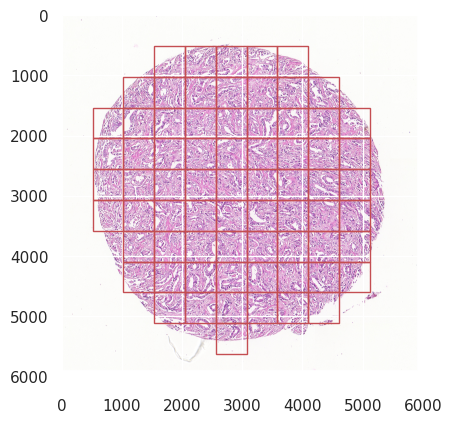

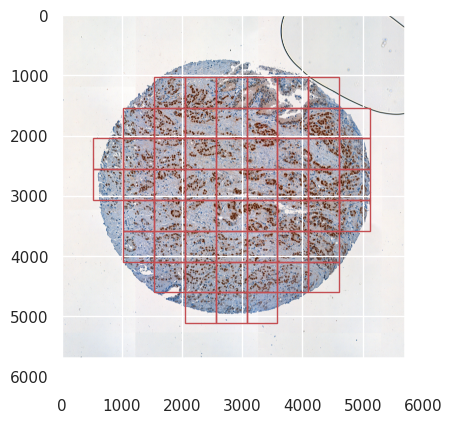

In [5]:
patches_src = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_src.antibodies[0])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_src.antibodies[0]))),
)

patches_dst = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_dst.antibodies[0])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_dst.antibodies[0]))),
)

In [6]:
# Define hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Define VAE
# 3. Instantiate the model
vae = VanillaEncoder(
    in_channels=3,
    latent_dim=64,  # You can choose a different latent dimension
    hidden_dims=[32, 64]
).to(device)

In [8]:
vae.count_dtypes()

torch.float32: 26 parameters


In [9]:
test_patch_src = patches_src[10]
test_patch_dst = patches_dst[10]


test_patch_src_tensor = Utilities.convert_numpy_to_tensor(test_patch_src)
test_patch_dst_tensor = Utilities.convert_numpy_to_tensor(test_patch_dst)

print("test_patch_src_tensor shape: ", test_patch_src_tensor.shape)
print("test_patch_dst_tensor shape: ", test_patch_dst_tensor.shape)

test_patch_src_tensor shape:  torch.Size([1, 3, 512, 512])
test_patch_dst_tensor shape:  torch.Size([1, 3, 512, 512])


In [10]:
test_patch_src_tensor = test_patch_src_tensor.to(device)

en = vae(test_patch_src_tensor)
en.shape

torch.Size([1, 64, 128, 128])

In [11]:
# Define UNET
# Create model with matching in_channels
model = AdaINUNet(
    in_channels=64,  # Changed from 3 to 64 to match your input
    out_channels=3,
    time_emb_dim=128,
    base_channels=64,
    channel_mults=(1, 2, 4, 8),  # Creates a model with 4 resolution levels
    num_res_blocks=2,            # 2 residual blocks per resolution
    attention_resolutions=(4, 8),  # Add attention at 8×8 and 16×16 resolutions
    dropout=0.1,
    style_strength=1.0,
    device=device
).to(device)

In [12]:
model.count_dtypes()

torch.float32: 298 parameters


In [13]:
# Define StyleExtractor
extractor = StyleExtractor()
extractor = extractor.to(device='cuda')
encoded = extractor(test_patch_src_tensor)

encoded.view(1, 64, 128, 128).shape

/root/miniconda3/envs/flashenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/flashenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 64, 128, 128])

In [14]:
# Define Decoder
decoder = VanillaDecoder(in_channels=64, latent_dim=64, output_channels=3).to('cuda')  # [1, 64, 64, 64]

In [15]:
pipeline = nn.Sequential(
    vae,
    model,
    decoder
).to(device='cuda')

In [16]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")


Number of trainable parameters: 61412480


In [17]:
count = 0
count_float32 = 0
for name, module in pipeline.named_modules():
    for param_name, param in module.named_parameters(recurse=False):
        # print(f"{name}.{param_name}: dtype={param.dtype}")
        if param.dtype == torch.float32:
            count_float32 += 1
        count += 1

print(f"float32 percentage: {count_float32 / count * 100}%")


float32 percentage: 100.0%


In [ ]:
# Hyperparameters
num_epochs = 20
batch_size = 1
lr = 1e-3
losses = []
optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], 
                        lr=lr, weight_decay=1e-6, eps=1e-8)

channels = 64  # This should match in_channels of the model
height, width = 128, 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# lambda_structure = 0.001
lambda_content = 0.001
# lambda_style = 0.0001
# lambda_color = 1e6

lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

# Training loop
# Put on training mode
model.train()
vae.train()
decoder.train()
extractor.train()
requires_grad = True


# Switch to main training with bfloat16
for epoch in tqdm(range(num_epochs)):
    # print(f"Epoch {epoch+1}/{num_epochs}")
    epoch_losses = []
    
    avg_loss = []
    for i, (src, dst) in enumerate(zip(patches_src, patches_dst)):
        # Convert to tensors
        src_tensor = Utilities.convert_numpy_to_tensor(src).to(device)
        dst_tensor = Utilities.convert_numpy_to_tensor(dst).to(device)

        # Extract style
        style_emb = extractor(dst_tensor)
        # print(f"After module {i} ({type(extractor)}), requires_grad: {style_emb.requires_grad}")
        style_flat = style_emb.to(device='cuda')  # [1, 64, 16384]
        style = style_flat.view(batch_size, channels, height, width)

        timesteps = torch.randint(0, 1000, (batch_size,), device=device)  # Random timesteps

        # Encode 
        encoded = vae(src_tensor)
        # print(f"After module {i} ({type(vae)}), requires_grad: {encoded.requires_grad}")

        # Pass through UNet
        unet_out = model(encoded, timesteps, style)
        # print(f"After module {i} ({type(model)}), requires_grad: {unet_out.requires_grad}")

        # Decode
        decoded = decoder(unet_out)
        # print(f"After module {i} ({type(decoder)}), requires_grad: {decoded.requires_grad}")

        # Handle gradients issues
        requires_grad = decoded.requires_grad and style_emb.requires_grad and encoded.requires_grad and unet_out.requires_grad
        # print(requires_grad)
        if not requires_grad:
            break

        # Compute losses
        content_l = lambda_content * content_loss(
                    original_image=src_tensor,
                    generated_image=decoded,
                    lambda_content=1.0  # Using 1.0 here since we're scaling outside
                )

        total_loss = content_l # + color_l # + style_l  # + structure_l

        avg_loss.append(total_loss.item())


        # print("total_loss: ", total_loss)

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    # losses.append(total_loss.item())
    losses.append(np.sum(avg_loss) / len(avg_loss))

 30%|███       | 6/20 [00:47<01:48,  7.76s/it]

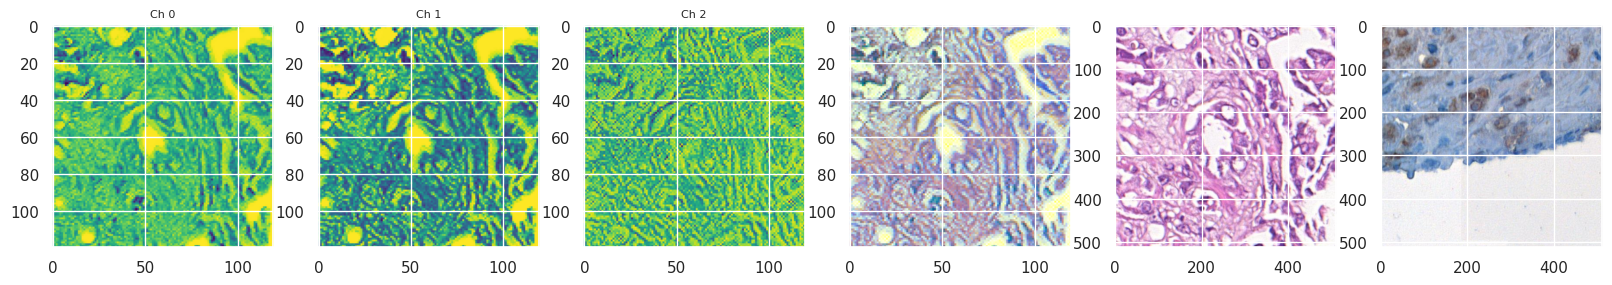

In [ ]:
decoded = decoded.to(torch.uint8)
fig, axes = plt.subplots(1, 6, figsize=(20, 15))  # 1x5 grid
for i in range(3):
    ax = axes[i]
    ax.imshow(decoded[0, i].detach().cpu().numpy(), cmap='viridis')
    ax.set_title(f'Ch {i}', fontsize=8)
    # ax.axis('off')

axes[3].imshow(decoded[0].permute(1,2,0).detach().cpu().numpy(), cmap='viridis')
axes[4].imshow(src, cmap='viridis')
axes[5].imshow(dst, cmap='viridis')

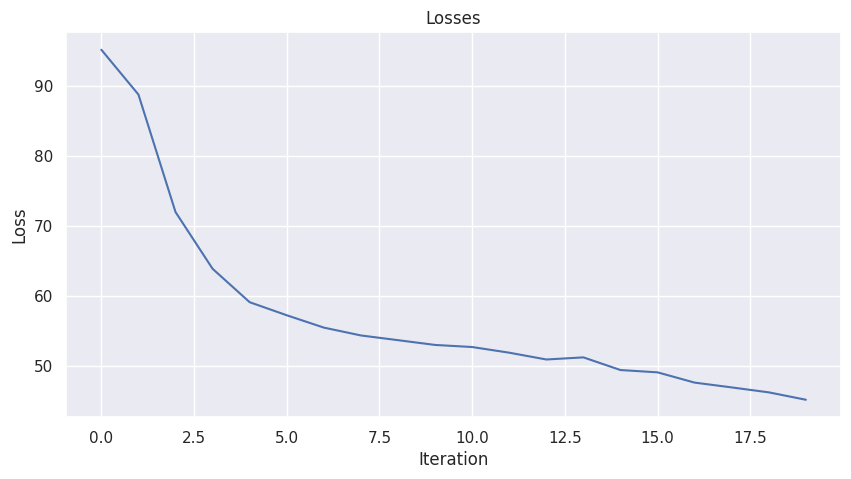

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(losses, label='Loss')
plt.title('Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()